# GRN Inference on Pre-trained Model
Here we use the pre-trained blood model as an example for GRN inference, particularly regarding gene program extraction and network visualization. We also present the cell-type specific activations within these gene programs on the Immune Human dataset, as a soft validation for the zero-shot performance. 

Note that GRN inference can be performed on pre-trained and finetuned models as showcased in our manuscript.

Users may perform scGPT's gene-embedding-based GRN inference in the following steps:

     1. Load optimized scGPT model (pre-trained or fine-tuned) and data
     
     2. Retrieve scGPT's gene embeddings
     
     3. Extract gene programs from scGPT's gene embedding network
     
     4. Visualize gene program activations on dataset of interest
     
     5. Visualize the interconnectivity of genes within select gene programs
     

In [1]:
import copy
import json
import os
from pathlib import Path
import sys
import warnings

import torch
from anndata import AnnData
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import tqdm
import gseapy as gp
import pickle

from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

sys.path.insert(0, "../")
import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.model import TransformerModel
from scgpt.preprocess import Preprocessor
from scgpt.utils import set_seed 

os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

In [2]:
set_seed(42)
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
n_hvg = 1200
n_bins = 51
mask_value = -1
pad_value = -2
n_input_bins = n_bins

## Step 1: Load pre-trained model and dataset

### 1.1  Load pre-trained model
The blood pre-trained model can be downloaded via this [link](https://drive.google.com/drive/folders/1kkug5C7NjvXIwQGGaGoqXTk_Lb_pDrBU).

In [3]:
# Specify model path; here we load the pre-trained scGPT blood model
# model_dir = Path("../save/scGPT_bc")
model_dir = Path("/data4/zhuyiheng/wjl/scFM-Bench/data/weights/scgpt/scGPT_human")
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
vocab_file = model_dir / "vocab.json"

vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

# Retrieve model parameters from config files
with open(model_config_file, "r") as f:
    model_configs = json.load(f)
print(
    f"Resume model from {model_file}, the model args will override the "
    f"config {model_config_file}."
)
embsize = model_configs["embsize"]
nhead = model_configs["nheads"]
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs["n_layers_cls"]

gene2idx = vocab.get_stoi()

Resume model from /data4/zhuyiheng/wjl/scFM-Bench/data/weights/scgpt/scGPT_human/best_model.pt, the model args will override the config /data4/zhuyiheng/wjl/scFM-Bench/data/weights/scgpt/scGPT_human/args.json.


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_value=pad_value,
    n_input_bins=n_input_bins,
)

try:
    model.load_state_dict(torch.load(model_file))
    print(f"Loading all model params from {model_file}")
except:
    # only load params that are in the model and match the size
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        print(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)

Loading params encoder.embedding.weight with shape torch.Size([60697, 512])
Loading params encoder.enc_norm.weight with shape torch.Size([512])
Loading params encoder.enc_norm.bias with shape torch.Size([512])
Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
Loading params value_encoder.linear1.bias with shape torch.Size([512])
Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
Loading params value_encoder.linear2.bias with shape torch.Size([512])
Loading params value_encoder.norm.weight with shape torch.Size([512])
Loading params value_encoder.norm.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.self_attn.out_proj.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.linear1.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.linear1.bias with 

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwis

### 1.2  Load dataset of interest
The Immune Human dataset can be downloaded via this [link](https://figshare.com/ndownloader/files/25717328).

In [5]:
# Specify data path; here we load the Immune Human dataset
# data_dir = Path("../data")
data_dir = Path("../data/datasets")
adata = sc.read(
    str(data_dir / "Immune_all_human.h5ad"), cache=True
)  # 33506 × 12303
print(adata.shape)
ori_batch_col = "batch"
adata.obs["celltype"] = adata.obs["final_annotation"].astype(str)
data_is_raw = False

(33506, 12303)


In [6]:
# Preprocess the data following the scGPT data pre-processing pipeline
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key="batch")

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Filtering cells by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - INFO - Binning data ...


In [7]:
adata.shape

(33506, 1200)

In [8]:
# save selected genes
with open("../data/GRN_analysis/Immune_all_human/selected_gene_list.txt", "w") as f:
    for gene in adata.var_names:
        f.write(gene + "\n")

## Step 2: Retrieve gene embeddings

Note that technically scGPT's gene embeddings are data independent. Overall, the pre-trained foundation model contains 30+K genes. Here for simplicity, we focus on a subset of HVGs specific to the data at hand.

Extract and save gene embeddings for the dataset of interest (Immune_all_human).

### 2.1 Dataset independent gene embeddings

#### scGPT

In [43]:
# Retrieve the data-independent gene embeddings from scGPT
gene_ids = np.array([id for id in gene2idx.values()])
gene_embeddings = model.encoder(torch.tensor(gene_ids, dtype=torch.long).to(device)) # gene encoder
gene_embeddings = gene_embeddings.detach().cpu().numpy()

../aten/src/ATen/native/cuda/Indexing.cu:1141: indexSelectLargeIndex: block: [118,0,0], thread: [96,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1141: indexSelectLargeIndex: block: [118,0,0], thread: [97,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1141: indexSelectLargeIndex: block: [118,0,0], thread: [98,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1141: indexSelectLargeIndex: block: [118,0,0], thread: [99,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1141: indexSelectLargeIndex: block: [118,0,0], thread: [100,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1141: indexSelectLargeIndex: block: [118,0,0], thread: [101,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1141: indexSelectLargeIndex: block: [11

In [44]:
# Filter on the intersection between the Immune Human HVGs found in step 1.2 and scGPT's 30+K foundation model vocab
gene_embeddings = {gene: gene_embeddings[i] for i, gene in enumerate(gene2idx.keys()) if gene in adata.var.index.tolist()}
print('Retrieved gene embeddings for {} genes.'.format(len(gene_embeddings)))

Retrieved gene embeddings for 1176 genes.


In [45]:
gene_embeddings["FGR"].shape

(512,)

In [ ]:
# Construct gene embedding network
embed = GeneEmbedding(gene_embeddings)

#### Geneformer

In [46]:
from transformers import BertForMaskedLM
saved_model_path = "/data2/zhuyiheng/wjl/scFoundation/data/weights/Geneformer/default/12L"
model = BertForMaskedLM.from_pretrained(saved_model_path,
                                        output_attentions=False,
                                        output_hidden_states=True)

In [47]:
dict_paths = "/data2/zhuyiheng/wjl/scFoundation/data/weights/Geneformer/dicts"
token_dictionary_path = os.path.join(dict_paths, "token_dictionary.pkl")
with open(token_dictionary_path, "rb") as f:
    vocab = pickle.load(f)

pad_token_id = vocab.get("<pad>")

# size of vocabulary
vocab_size = len(vocab)  

gene_name_id_path = os.path.join(dict_paths, "gene_name_id_dict.pkl")
with open(gene_name_id_path, "rb") as f:
    gene_name_id = pickle.load(f)

In [48]:
gene_embeddings = model.state_dict()['bert.embeddings.word_embeddings.weight'].numpy()
gene_embeddings.shape

(25426, 512)

In [49]:
gene_id_name = {v: k for k, v in gene_name_id.items()}
gene_id_name

{'ENSG00000210049': 'MT-TF',
 'ENSG00000211459': 'MT-RNR1',
 'ENSG00000210077': 'MT-TV',
 'ENSG00000210082': 'MT-RNR2',
 'ENSG00000209082': 'MT-TL1',
 'ENSG00000198888': 'MT-ND1',
 'ENSG00000210100': 'MT-TI',
 'ENSG00000210107': 'MT-TQ',
 'ENSG00000210112': 'MT-TM',
 'ENSG00000198763': 'MT-ND2',
 'ENSG00000210117': 'MT-TW',
 'ENSG00000210127': 'MT-TA',
 'ENSG00000210135': 'MT-TN',
 'ENSG00000210140': 'MT-TC',
 'ENSG00000210144': 'MT-TY',
 'ENSG00000198804': 'MT-CO1',
 'ENSG00000210151': 'MT-TS1',
 'ENSG00000210154': 'MT-TD',
 'ENSG00000198712': 'MT-CO2',
 'ENSG00000210156': 'MT-TK',
 'ENSG00000228253': 'MT-ATP8',
 'ENSG00000198899': 'MT-ATP6',
 'ENSG00000198938': 'MT-CO3',
 'ENSG00000210164': 'MT-TG',
 'ENSG00000198840': 'MT-ND3',
 'ENSG00000210174': 'MT-TR',
 'ENSG00000212907': 'MT-ND4L',
 'ENSG00000198886': 'MT-ND4',
 'ENSG00000210176': 'MT-TH',
 'ENSG00000210184': 'MT-TS2',
 'ENSG00000210191': 'MT-TL2',
 'ENSG00000198786': 'MT-ND5',
 'ENSG00000198695': 'MT-ND6',
 'ENSG00000210194': 

In [50]:
vocab.keys()

dict_keys(['<pad>', '<mask>', 'ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419', 'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938', 'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084', 'ENSG00000001167', 'ENSG00000001460', 'ENSG00000001461', 'ENSG00000001497', 'ENSG00000001561', 'ENSG00000001617', 'ENSG00000001626', 'ENSG00000001629', 'ENSG00000001630', 'ENSG00000001631', 'ENSG00000002016', 'ENSG00000002330', 'ENSG00000002549', 'ENSG00000002586', 'ENSG00000002587', 'ENSG00000002726', 'ENSG00000002745', 'ENSG00000002746', 'ENSG00000002822', 'ENSG00000002834', 'ENSG00000002919', 'ENSG00000002933', 'ENSG00000003056', 'ENSG00000003096', 'ENSG00000003137', 'ENSG00000003147', 'ENSG00000003249', 'ENSG00000003393', 'ENSG00000003400', 'ENSG00000003402', 'ENSG00000003436', 'ENSG00000003509', 'ENSG00000003756', 'ENSG00000003987', 'ENSG00000003989', 'ENSG00000004059', 'ENSG00000004139', 'ENSG00000004142', 'ENSG00000004399', 'ENSG00000004455', 'ENSG00000004468', 'ENSG00000004478', '

In [51]:
gene_embeddings = {gene_id_name[gene]: gene_embeddings[i] for i, gene in enumerate(vocab.keys()) if gene_id_name.get(gene, None) in adata.var.index.tolist()}
print('Retrieved gene embeddings for {} genes.'.format(len(gene_embeddings)))

Retrieved gene embeddings for 1166 genes.


In [53]:
gene_embeddings["FGR"].shape

(512,)

In [54]:
# Construct gene embedding network
embed = GeneEmbedding(gene_embeddings)

100%|██████████| 1166/1166 [00:00<00:00, 1427483.50it/s]


#### LangCell

In [71]:
sys.path.append("/data2/zhuyiheng/wjl/scFoundation/LangCell/LangCell-annotation-zeroshot")

In [73]:
from transformers import BertTokenizer, BertModel
from utils import LangCellDataCollatorForCellClassification as DataCollatorForCellClassification
model = BertModel.from_pretrained('/data2/zhuyiheng/wjl/scFoundation/LangCell/ckpt/cell_bert')

Some weights of BertModel were not initialized from the model checkpoint at /data2/zhuyiheng/wjl/scFoundation/LangCell/ckpt/cell_bert and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [76]:
gene_embeddings = model.state_dict()['embeddings.word_embeddings.weight'].numpy()
gene_embeddings.shape

(25427, 512)

In [77]:
gene_embeddings = {gene_id_name[gene]: gene_embeddings[i] for i, gene in enumerate(vocab.keys()) if gene_id_name.get(gene, None) in adata.var.index.tolist()}
print('Retrieved gene embeddings for {} genes.'.format(len(gene_embeddings)))

Retrieved gene embeddings for 1166 genes.


In [78]:
# Construct gene embedding network
embed = GeneEmbedding(gene_embeddings)

100%|██████████| 1166/1166 [00:00<00:00, 1135490.70it/s]


#### UCE

In [88]:
gene_embeddings = torch.load("/data2/zhuyiheng/wjl/scFoundation/UCE/model_files/protein_embeddings/Homo_sapiens.GRCh38.gene_symbol_to_embedding_ESM2.pt")
gene_embeddings

{'A1BG': tensor([ 0.0438,  0.0198,  0.1622,  ..., -0.0156, -0.1479, -0.0697]),
 'A1CF': tensor([ 0.1535,  0.0120,  0.1064,  ..., -0.0549, -0.0816, -0.1205]),
 'A2M': tensor([ 0.1188, -0.0098,  0.0257,  ..., -0.0525, -0.1833,  0.0552]),
 'A2ML1': tensor([ 0.1116,  0.0864,  0.1390,  ..., -0.0241, -0.0946, -0.0376]),
 'A3GALT2': tensor([ 0.2336, -0.0101,  0.0746,  ...,  0.0974, -0.0539, -0.1045]),
 'A4GALT': tensor([ 0.2889, -0.0489, -0.0015,  ...,  0.0509, -0.2374, -0.1013]),
 'A4GNT': tensor([ 0.3216, -0.1067, -0.0043,  ...,  0.0464, -0.1839, -0.0540]),
 'AAAS': tensor([ 0.3111,  0.0813,  0.0676,  ..., -0.0392, -0.0691, -0.1456]),
 'AACS': tensor([ 0.2214,  0.0833,  0.0660,  ..., -0.0926, -0.1669, -0.0536]),
 'AADAC': tensor([ 0.0688,  0.0223,  0.0422,  ...,  0.0151, -0.1159, -0.0562]),
 'AADACL2': tensor([ 0.1155, -0.0013,  0.1282,  ..., -0.0227, -0.0731, -0.0911]),
 'AADACL3': tensor([ 0.0374,  0.0348,  0.1431,  ...,  0.0187, -0.1263, -0.0804]),
 'AADACL4': tensor([ 0.0397,  0.0150,  

In [89]:
gene_embeddings = {k: v.numpy() for k,v in gene_embeddings.items() if k in adata.var.index.tolist()}
print('Retrieved gene embeddings for {} genes.'.format(len(gene_embeddings)))

Retrieved gene embeddings for 1169 genes.


In [90]:
# Construct gene embedding network
embed = GeneEmbedding(gene_embeddings)

100%|██████████| 1169/1169 [00:00<00:00, 1467127.88it/s]


#### xTrimoGene

In [103]:
env_path = "/data2/zhuyiheng/wjl/scFoundation"
sys.path.append(env_path)
from xTrimoGene.model.load import load_model_frommmf

In [109]:
gene_list_file = "/data2/zhuyiheng/wjl/scFoundation/xTrimoGene/OS_scRNA_gene_index.19264.tsv"
gene_list_df = pd.read_csv(gene_list_file, header=0, delimiter='\t')
gene_list = list(gene_list_df['gene_name'])
gene_list

['A1BG',
 'A1CF',
 'A2M',
 'A2ML1',
 'A3GALT2',
 'A4GALT',
 'A4GNT',
 'AAAS',
 'AACS',
 'AADAC',
 'AADACL2',
 'AADACL3',
 'AADACL4',
 'AADAT',
 'AAGAB',
 'AAK1',
 'AAMDC',
 'AAMP',
 'AANAT',
 'AAR2',
 'AARD',
 'AARS1',
 'AARS2',
 'AARSD1',
 'AASDH',
 'AASDHPPT',
 'AASS',
 'AATF',
 'AATK',
 'ABAT',
 'ABCA1',
 'ABCA10',
 'ABCA12',
 'ABCA13',
 'ABCA2',
 'ABCA3',
 'ABCA4',
 'ABCA5',
 'ABCA6',
 'ABCA7',
 'ABCA8',
 'ABCA9',
 'ABCB1',
 'ABCB10',
 'ABCB11',
 'ABCB4',
 'ABCB5',
 'ABCB6',
 'ABCB7',
 'ABCB8',
 'ABCB9',
 'ABCC1',
 'ABCC10',
 'ABCC11',
 'ABCC12',
 'ABCC2',
 'ABCC3',
 'ABCC4',
 'ABCC5',
 'ABCC6',
 'ABCC8',
 'ABCC9',
 'ABCD1',
 'ABCD2',
 'ABCD3',
 'ABCD4',
 'ABCE1',
 'ABCF1',
 'ABCF2',
 'ABCF3',
 'ABCG1',
 'ABCG2',
 'ABCG4',
 'ABCG5',
 'ABCG8',
 'ABHD1',
 'ABHD10',
 'ABHD11',
 'ABHD12',
 'ABHD12B',
 'ABHD13',
 'ABHD14A',
 'ABHD14B',
 'ABHD15',
 'ABHD16A',
 'ABHD16B',
 'ABHD17A',
 'ABHD17B',
 'ABHD17C',
 'ABHD18',
 'ABHD2',
 'ABHD3',
 'ABHD4',
 'ABHD5',
 'ABHD6',
 'ABHD8',
 'ABI1',
 '

In [105]:
ckpt_path = "/data2/zhuyiheng/wjl/scFoundation/xTrimoGene/model/models/models.ckpt"
key = "cell"
pretrainmodel, pretrainconfig = load_model_frommmf(ckpt_path, key)

{'mask_gene_name': False, 'gene_num': 19266, 'seq_len': 19266, 'encoder': {'hidden_dim': 768, 'depth': 12, 'heads': 12, 'dim_head': 64, 'seq_len': 19266, 'module_type': 'transformer', 'norm_first': False}, 'decoder': {'hidden_dim': 512, 'depth': 6, 'heads': 8, 'dim_head': 64, 'module_type': 'performer', 'seq_len': 19266, 'norm_first': False}, 'n_class': 104, 'pad_token_id': 103, 'mask_token_id': 102, 'bin_num': 100, 'bin_alpha': 1.0, 'rawcount': True, 'model': 'mae_autobin', 'test_valid_train_idx_dict': '/nfs_beijing/minsheng/data/os10000w-new/global_shuffle/meta.csv.train_set_idx_dict.pt', 'valid_data_path': '/nfs_beijing/minsheng/data/valid_count_10w.npz', 'num_tokens': 13, 'train_data_path': None, 'isPanA': False, 'isPlanA1': False, 'max_files_to_load': 5, 'bin_type': 'auto_bin', 'value_mask_prob': 0.3, 'zero_mask_prob': 0.03, 'replace_prob': 0.8, 'random_token_prob': 0.1, 'mask_ignore_token_ids': [0], 'decoder_add_zero': True, 'mae_encoder_max_seq_len': 15000, 'isPlanA': False, 'ma

In [118]:
gene_embeddings = pretrainmodel.pos_emb.weight.detach().numpy()[:19264,:]
gene_embeddings.shape

(19264, 768)

In [119]:
gene_embeddings = {gene: gene_embeddings[i] for i, gene in enumerate(gene_list) if gene in adata.var.index.tolist()}
print('Retrieved gene embeddings for {} genes.'.format(len(gene_embeddings)))

Retrieved gene embeddings for 1170 genes.


In [120]:
# Construct gene embedding network
embed = GeneEmbedding(gene_embeddings)

100%|██████████| 1170/1170 [00:00<00:00, 1479896.16it/s]


### 2.2 Dataset dependent gene embeddings

## Step 3: Extract gene programs from gene embedding network

### 3.1  Perform Louvain clustering on the gene embedding network

In [121]:
# Perform Louvain clustering with desired resolution; here we specify resolution=40
gdata = embed.get_adata(resolution=40)
# Retrieve the gene clusters
metagenes = embed.get_metagenes(gdata)

... storing 'Metagene 21' as categorical


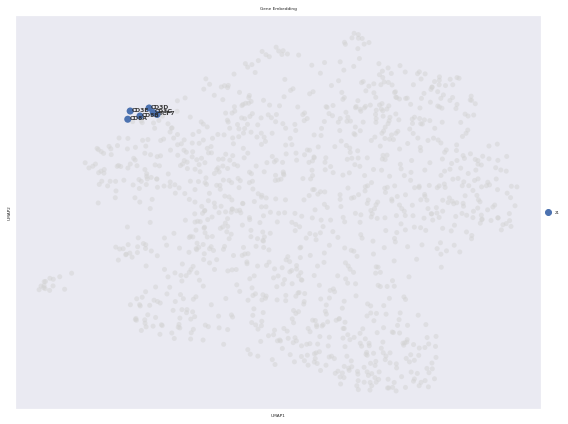

In [33]:
embed.plot_metagene(gdata, mg="21")

### 3.2  Filter on clusters with 5 or more genes

In [132]:
gdata = embed.get_adata(resolution=40)
# Retrieve the gene clusters
metagenes = embed.get_metagenes(gdata)

In [133]:
# Obtain the set of gene programs from clusters with #genes >= 5
mgs = dict()
for mg, genes in metagenes.items():
    # if len(genes) > 4:
        # mgs[mg] = genes
    mgs[mg] = genes

In [134]:
# Here are the gene programs identified
mgs

{'148': ['ABCA5', 'CCNDBP1', 'STOM'],
 '135': ['ABCB4', 'ACTN1', 'ITGB3'],
 '84': ['ABCG2', 'CX3CR1', 'FAM13A', 'PAX5'],
 '24': ['ABI3', 'ELANE', 'LYAR', 'SLC35D3', 'SPI1'],
 '220': ['ABLIM1', 'RASD1', 'ZFAND5'],
 '134': ['ABLIM3', 'TBCEL', 'TTC39B'],
 '12': ['ACP5', 'CEP290', 'FOS', 'GIMAP6', 'PRKAR1B'],
 '114': ['ACRBP', 'ID1', 'MXD1', 'SLC38A11'],
 '236': ['ACSL1', 'RHOC', 'SLC2A3'],
 '50': ['ACSL6', 'CLEC1B', 'DNAJB2', 'PLEKHG1'],
 '264': ['ACVR1C', 'STXBP2'],
 '316': ['ADAM28', 'KRT5'],
 '165': ['ADAMTS5', 'CPA3', 'CPEB4'],
 '18': ['ADM', 'C1QB', 'FCER1G', 'GPR155', 'TIMP1'],
 '57': ['ADRB2', 'BCL11A', 'SH2D1A', 'STX7'],
 '250': ['AFF3', 'GPR183', 'TSC22D1'],
 '200': ['AGTRAP', 'CTSW', 'LTBP1'],
 '336': ['AHNAK', 'QKI'],
 '106': ['AHR', 'FKBP11', 'MICAL3', 'PLEK2'],
 '209': ['AIF1', 'IFIT1', 'NSUN3'],
 '36': ['AIM2', 'NLRP3', 'STRBP', 'ZCCHC7'],
 '99': ['AK1', 'LPAR5', 'LPIN2', 'MTMR3'],
 '136': ['AK5', 'CDC25B', 'FAM214B'],
 '34': ['AKTIP', 'CHI3L2', 'PHACTR1', 'S1PR3', 'TGFBI'],

## Step 4: Visualize gene program activation on the Immune Human dataset

<Figure size 360x936 with 0 Axes>

<Figure size 432x288 with 0 Axes>

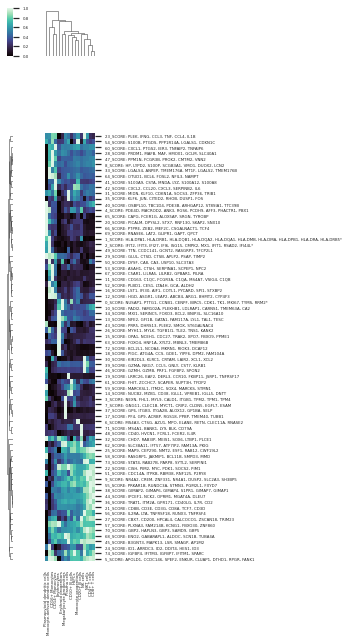

In [13]:
sns.set(font_scale=0.35)
embed.score_metagenes(adata, metagenes)
embed.plot_metagenes_scores(adata, mgs, "celltype")

## Step 5: Visualize network connectivity within desired gene program
We can further visualize the connectivity between genes within any gene program of interest from Step 4. Here is an example of gene program 3 consisting of the CD3 cluster, CD8 cluster and other genes. In the visualization, we see strong connections highlighted in blue (by cosine similarity) between CD3D, E, and G, as well as CD8A and B.

In [82]:
# Retrieve gene program 3 which contains the CD3 gene set
CD_genes = mgs['201']
print(CD_genes)
# Compute cosine similarities among genes in this gene program
df_CD = pd.DataFrame(columns=['Gene', 'Similarity', 'Gene1'])
for i in tqdm.tqdm(CD_genes):
    df = embed.compute_similarities(i, CD_genes)
    df['Gene1'] = i
    # df_CD = df_CD.append(df)
    df_CD = pd.concat([df_CD, df], ignore_index=True)
df_CD_sub = df_CD[df_CD['Similarity']<0.99].sort_values(by='Gene') # Filter out edges from each gene to itself

['CD3G', 'CD3D', 'CD3E']


100%|██████████| 3/3 [00:00<00:00, 404.18it/s]


In [15]:
# Creates a graph from the cosine similarity network
input_node_weights = [(row['Gene'], row['Gene1'], round(row['Similarity'], 2)) for i, row in df_CD_sub.iterrows()]
G = nx.Graph()
G.add_weighted_edges_from(input_node_weights)

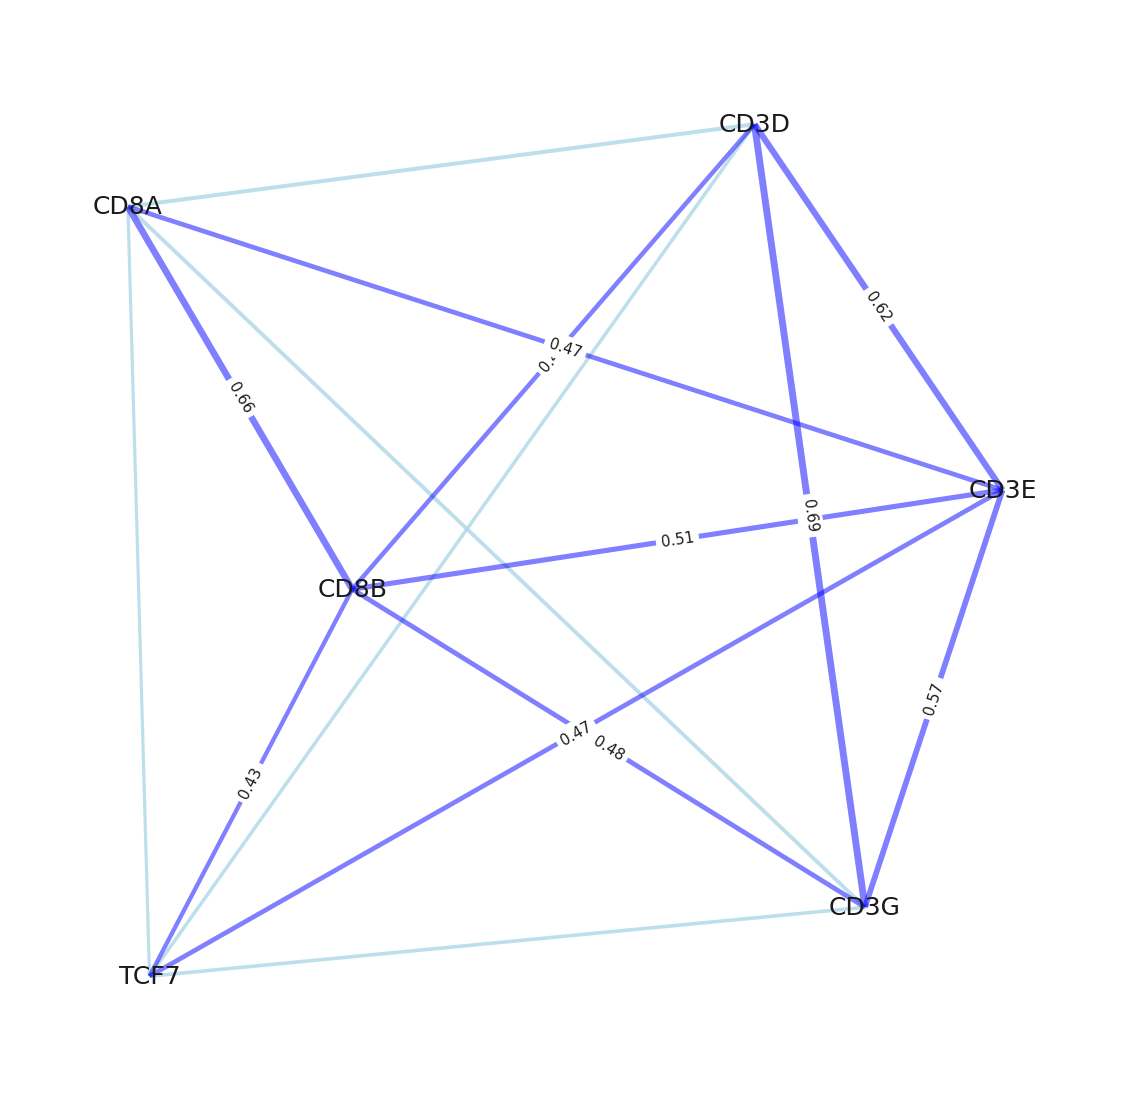

In [16]:
# Plot the cosine similarity network; strong edges (> select threshold) are highlighted
thresh = 0.4
plt.figure(figsize=(20, 20))
widths = nx.get_edge_attributes(G, 'weight')

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > thresh]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= thresh]

pos = nx.spring_layout(G, k=0.4, iterations=15, seed=3)

width_large = {}
width_small = {}
for i, v in enumerate(list(widths.values())):
    if v > thresh:
        width_large[list(widths.keys())[i]] = v*10
    else:
        width_small[list(widths.keys())[i]] = max(v, 0)*10

nx.draw_networkx_edges(G, pos,
                       edgelist = width_small.keys(),
                       width=list(width_small.values()),
                       edge_color='lightblue',
                       alpha=0.8)
nx.draw_networkx_edges(G, pos, 
                       edgelist = width_large.keys(), 
                       width = list(width_large.values()), 
                       alpha = 0.5, 
                       edge_color = "blue", 
                      )
# node labels
nx.draw_networkx_labels(G, pos, font_size=25, font_family="sans-serif")
# edge weight labels
d = nx.get_edge_attributes(G, "weight")
edge_labels = {k: d[k] for k in elarge}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.show()

## Step 6: Reactome pathway analysis
Again with gene program 3 as an example, users may perform pathway enrichment analysis to identify related pathways. In the paper, we used the Bonferroni correction to adjust the p-value threshold by accounting for the total number of tests performed.

In [ ]:
#! select the group contains 'CD3D' gene
CD_genes = mgs['42']

In [136]:
# Meta info about the number of terms (tests) in the databases
df_database = pd.DataFrame(
data = [['GO_Biological_Process_2021', 6036],
['GO_Molecular_Function_2021', 1274],
['Reactome_2022', 1818]],
columns = ['dataset', 'term'])
df_database

,dataset,term
0,GO_Biological_Process_2021,6036
1,GO_Molecular_Function_2021,1274
2,Reactome_2022,1818


In [137]:
# Select desired database for query; here use Reactome as an example
databases = ['Reactome_2022']
m = df_database[df_database['dataset'].isin(databases)]['term'].sum()
# p-value correction for total number of tests done
p_thresh = 0.05/m

In [ ]:
# Perform pathway enrichment analysis using the gseapy package in the Reactome database
df = pd.DataFrame()
enr_Reactome = gp.enrichr(gene_list=CD_genes,
                          gene_sets=databases,
                          organism='Human', 
                          outdir='test/enr_Reactome',
                          cutoff=0.5)
out = enr_Reactome.results
out = out[out['P-value'] < p_thresh]
print(len(out))
# out.to_csv('test/enr_Reactome/enrichr_Reactome.csv')
out

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,Reactome_2022,Neurofascin Interactions R-HSA-447043,1/7,0.001399,0.020036,0,0,1110.555556,7298.297606,ANK1
1,Reactome_2022,NrCAM Interactions R-HSA-447038,1/7,0.001399,0.020036,0,0,1110.555556,7298.297606,ANK1
2,Reactome_2022,CHL1 Interactions R-HSA-447041,1/9,0.001799,0.020036,0,0,832.833333,5263.996189,ANK1
3,Reactome_2022,"Synthesis Of IP2, IP, And Ins In Cytosol R-HSA...",1/14,0.002797,0.020036,0,0,512.384615,3012.374505,INPP4B
4,Reactome_2022,Synthesis Of PIPs At Early Endosome Membrane R...,1/16,0.003196,0.020036,0,0,444.022222,2551.238662,INPP4B
5,Reactome_2022,Translocation Of ZAP-70 To Immunological Synap...,1/17,0.003396,0.020036,0,0,416.250000,2366.462633,CD3D
6,Reactome_2022,Defective GALNT12 Causes CRCS1 R-HSA-5083636,1/18,0.003595,0.020036,0,0,391.745098,2204.785214,GALNT12
7,Reactome_2022,Phosphorylation Of CD3 And TCR Zeta Chains R-H...,1/20,0.003994,0.020036,0,0,350.473684,1935.631384,CD3D
8,Reactome_2022,PD-1 Signaling R-HSA-389948,1/21,0.004194,0.020036,0,0,332.933333,1822.538786,CD3D
9,Reactome_2022,Membrane Trafficking R-HSA-199991,2/599,0.005162,0.020866,0,0,32.494137,171.129782,ANK1;CD3D


In [26]:
#! the ratio of significant pathways
scgpt_r = len(out[out['P-value'] < p_thresh]) / len(out)
scgpt_r

0.13157894736842105

In [68]:
geneformer_r = len(out[out['P-value'] < p_thresh]) / len(out)
geneformer_r

0.25

In [87]:
langcell_r = len(out[out['P-value'] < p_thresh]) / len(out)
langcell_r

0.2857142857142857

In [100]:
uce_r = len(out[out['P-value'] < p_thresh]) / len(out)
uce_r

0.19148936170212766

In [140]:
xtrimo_r = len(out[out['P-value'] < p_thresh]) / len(out)
xtrimo_r

0.0